In [1]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

dataset_path = "extracted_feature_set.json"

In [2]:
#loads the dataset
def load_dataset(dataset):
    with open(dataset, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y

In [3]:
def plot_history_of_accuracy(music_history):

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(music_history.history["accuracy"], label="train accuracy")
    axs[0].plot(music_history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(music_history.history["loss"], label="train error")
    axs[1].plot(music_history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [4]:
def initialize_datasets(test_size, validation_size):
    
    # load data
    X, y = load_dataset(dataset_path)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [5]:
def generate_cnn_model(input_shape):
    
    # build network topology
    music_model = keras.Sequential()

    # 1st conv layer
    music_model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    music_model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    music_model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    music_model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    music_model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    music_model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    music_model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    music_model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    music_model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    music_model.add(keras.layers.Flatten())
    music_model.add(keras.layers.Dense(64, activation='relu'))
    music_model.add(keras.layers.Dropout(0.3))

    # output layer
    music_model.add(keras.layers.Dense(10, activation='softmax'))

    return music_model

In [6]:
def prediction(music_model, X, y):

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = music_model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 11, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 6, 32)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 6, 32)         128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 4, 32)         9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 2, 32)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 2, 32)         128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 1, 32)         4

5997/5997 [==============================] - 13s 2ms/sample - loss: 0.5973 - accuracy: 0.7929 - val_loss: 0.7918 - val_accuracy: 0.7287
Epoch 43/50
5997/5997 [==============================] - 13s 2ms/sample - loss: 0.5860 - accuracy: 0.7962 - val_loss: 0.8004 - val_accuracy: 0.7280
Epoch 44/50
5997/5997 [==============================] - 13s 2ms/sample - loss: 0.5874 - accuracy: 0.7987 - val_loss: 0.8213 - val_accuracy: 0.7153
Epoch 45/50
5997/5997 [==============================] - 13s 2ms/sample - loss: 0.5834 - accuracy: 0.7967 - val_loss: 0.7836 - val_accuracy: 0.7353
Epoch 46/50
5997/5997 [==============================] - 13s 2ms/sample - loss: 0.5522 - accuracy: 0.8081 - val_loss: 0.8015 - val_accuracy: 0.7247
Epoch 47/50
5997/5997 [==============================] - 13s 2ms/sample - loss: 0.5585 - accuracy: 0.8097 - val_loss: 0.8134 - val_accuracy: 0.7360
Epoch 48/50
5997/5997 [==============================] - 13s 2ms/sample - loss: 0.5536 - accuracy: 0.8079 - val_loss: 0.7793

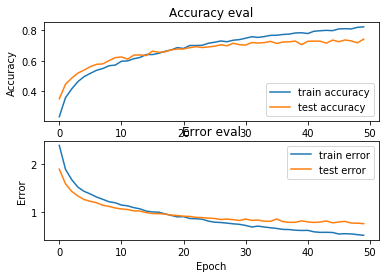

2499/1 - 1s - loss: 0.5001 - accuracy: 0.7283

Test accuracy: 0.72829133
Target: 9, Predicted label: [6]


In [7]:
if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = initialize_datasets(0.25, 0.2)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    music_model = generate_cnn_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    music_model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    music_model.summary()

    # train model
    history = music_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=50)

    # plot accuracy/error for training and validation
    plot_history_of_accuracy(history)

    # evaluate model on test set
    test_loss, test_acc = music_model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    # pick a sample to predict from the test set
    X_to_predict = X_test[100]
    y_to_predict = y_test[100]

    # predict sample
    prediction(music_model, X_to_predict, y_to_predict)